<a href="https://colab.research.google.com/github/manlio99/DeTodoUnPoco/blob/main/Unet_Image_segmentation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Image segmentation with CamVid

https://medium.com/analytics-vidhya/image-segmentation-using-fastai-ddded25f811e

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install torch==1.4 torchvision==0.5.0
!pip install fastai==1.0.61 

     |████████████████████████████████| 753.4 MB 7.3 kB/s 
     |████████████████████████████████| 4.0 MB 31.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.4.0 which is incompatible.


In [4]:
# !pip install fastdebug

# from fastdebug import *

In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [6]:
path_lbl = "/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/"
path_img = "/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/"


## Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/0.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/1.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/2.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/0.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/1.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/2.png')]

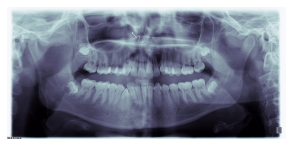

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [10]:
img.data.max()

tensor(1.)

In [11]:
# get_y_fn = lambda x: x
get_y_fn = lambda x: path_lbl+f'{x.stem}{x.suffix}'

In [12]:
img_f

PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/0.png')

In [13]:
get_y_fn(img_f)

'/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/0.png'

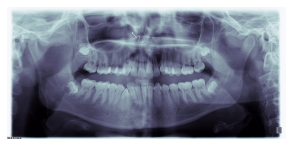

In [14]:
img = open_image(img_f)
img.show(figsize=(5,5))

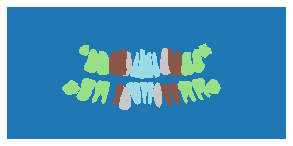

In [15]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [16]:
mask.data.max()

tensor(4)

In [17]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([302, 640]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [18]:
codes = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/labels.txt', dtype=str)
# codes = np.array(["molares", "premolares", "caninos", "incisivos"], dtype=str)
codes

array(['encia', 'molares', 'premolares', 'caninos', 'incisivos'], dtype='<U10')

## Datasets

adapte el dataset al tamaño de la imagen mas **pequeña**

In [19]:
size = (3, 302, 640)# src_size  #(360, 480) //2

free = gpu_mem_get_free_no_cache()
# if free > 8200: 
#   bs=8
# else:
#   bs=4
bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")
size

using bs=4, have 11438 MB of GPU RAM free


(3, 302, 640)

In [20]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(seed=1995)
       .label_from_func( get_y_fn, classes=codes)
       )
# .split_by _fname_file('../valid.txt')  .split_none()

In [21]:
src.transform(size=sise, tfm_y=True)
src.get_processors

<bound method LabelLists.get_processors of LabelLists;

Train: LabelList (44 items)
x: SegmentationItemList
Image (3, 302, 640),Image (3, 302, 640),Image (3, 1536, 3256),Image (3, 302, 640),Image (3, 1536, 3256)
y: SegmentationLabelList
ImageSegment (1, 302, 640),ImageSegment (1, 302, 640),ImageSegment (1, 1536, 3256),ImageSegment (1, 302, 640),ImageSegment (1, 1536, 3256)
Path: /content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images;

Valid: LabelList (10 items)
x: SegmentationItemList
Image (3, 302, 640),Image (3, 1536, 3256),Image (3, 1536, 3256),Image (3, 1536, 3256),Image (3, 302, 640)
y: SegmentationLabelList
ImageSegment (1, 302, 640),ImageSegment (1, 1536, 3256),ImageSegment (1, 1536, 3256),ImageSegment (1, 1536, 3256),ImageSegment (1, 302, 640)
Path: /content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images;

Test: None>

In [22]:
data = (src.transform(size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

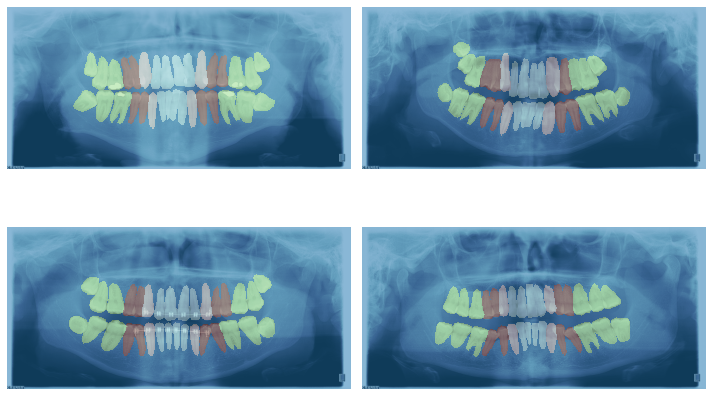

In [23]:
data.show_batch(2, figsize=(10, 7))

## Model

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id.values()

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [25]:
metrics = acc_camvid

In [26]:
wd = 1e-4

In [37]:
# create unet
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


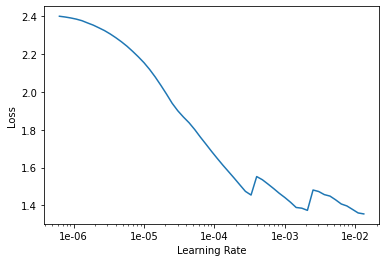

In [40]:
learn.recorder.plot()

In [41]:
lr = 1e-4

In [42]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.944435,1.357733,0.440792,00:21
1,1.476737,0.974581,0.806335,00:21
2,1.206787,0.675365,0.812533,00:21
3,1.001478,0.433728,0.829391,00:21
4,0.822863,0.380907,0.843819,00:22
5,0.687347,0.268426,0.894083,00:21
6,0.577638,0.227838,0.912027,00:22
7,0.490307,0.223994,0.914149,00:22
8,0.423066,0.199388,0.922351,00:22
9,0.366317,0.183015,0.928632,00:22


In [45]:
learn.save('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/fastai_dientes_original_1')


# learn.load('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/fastai_dientes_1');



## Aqui se ve la necesidad de cambiar la loss

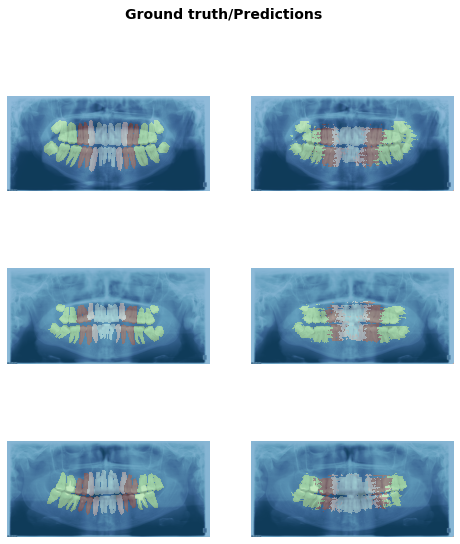

In [44]:
learn.show_results(rows=3, figsize=(8, 9))

In [46]:
learn.unfreeze()

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


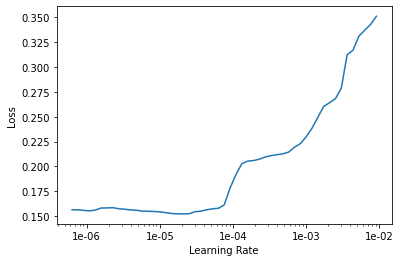

In [48]:
learn.recorder.plot()

## Aqui no sé si esta bien el lr pero los resultados son mejores

In [49]:
learn.fit_one_cycle(12, slice(1e-6, 1e-5), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.156704,0.180354,0.929727,00:22
1,0.155160,0.179131,0.930162,00:23
2,0.154133,0.179217,0.930514,00:23
3,0.152770,0.182098,0.929892,00:22
4,0.152046,0.185397,0.930218,00:22
5,0.150414,0.184665,0.931521,00:22
6,0.148100,0.188354,0.932062,00:22
7,0.146218,0.199118,0.930360,00:22
8,0.147413,0.222769,0.927378,00:22
9,0.151232,0.240039,0.925467,00:22


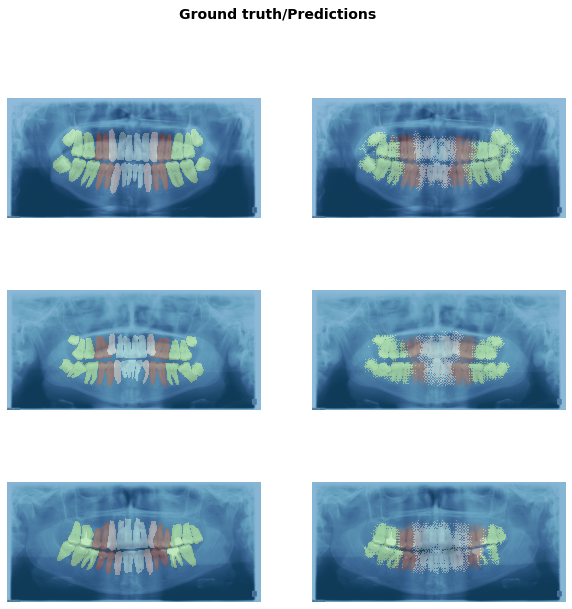

In [50]:
learn.show_results(rows=3, figsize=(10, 10))

In [51]:
learn.save('camvid-stage-2')

## Train on bigger images

In [52]:
size = (size[0], int(size[1]*1.5), int(size[2]*1.5))

In [53]:
size

(3, 453, 960)

In [54]:
learn.destroy()

# size = size *1.5

free = gpu_mem_get_free_no_cache()
if free > 8200: 
  bs=3
else: 
  bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 10420MB of GPU RAM free


In [55]:
data = (src.transform(size=size , tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

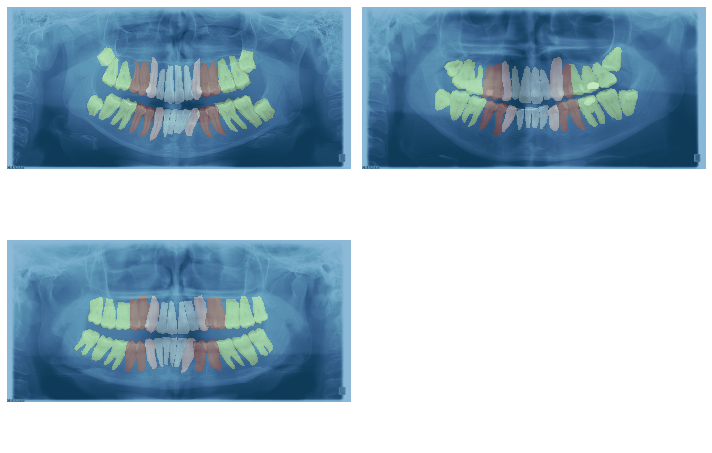

In [56]:
data.show_batch(2, figsize=(10, 7))

In [57]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [62]:
# learn.load('camvid-stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


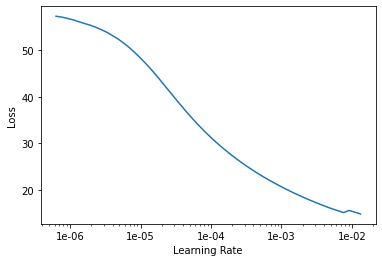

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
lr = 1e-3

In [61]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,8.388824,0.848719,0.804893,00:51
1,4.014246,0.554029,0.824673,00:43
2,2.462450,0.298964,0.889764,00:43
3,1.673581,0.244219,0.909986,00:43
4,1.205540,0.185193,0.926941,00:43
5,0.929437,0.304253,0.892016,00:43
6,0.725787,0.192568,0.926237,00:42
7,0.698174,0.565194,0.824090,00:43
8,0.631595,0.584224,0.864162,00:43
9,0.640314,0.818649,0.835781,00:43


In [63]:
learn.save('camvid-big-stage-1')

de nuevo problemas con el loss

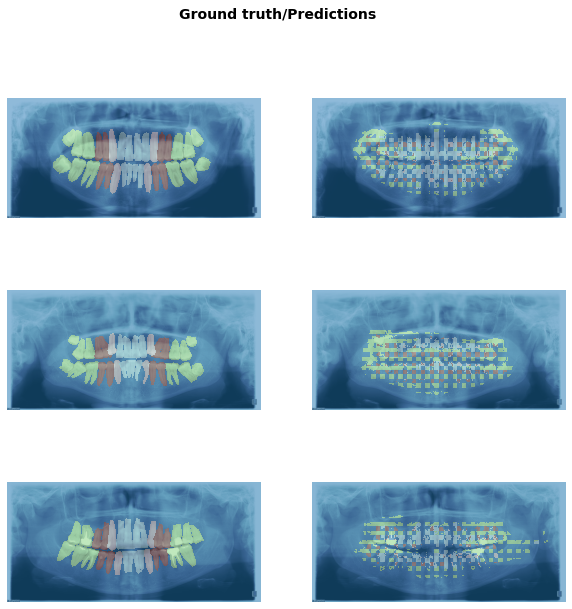

In [64]:
learn.show_results(rows=3, figsize=(10, 10))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, lr/10))

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.recorder.plot()

## Interpretation

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))